Importing All libraries

In [ ]:
# from google.colab import drive
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import cv2
from scipy import ndimage
from skimage.measure import EllipseModel
from scipy.optimize import least_squares
from scipy.interpolate import splprep, splev
from shapely.geometry import Polygon, MultiPolygon, GeometryCollection
from shapely.ops import unary_union
from shapely.validation import make_valid
from rdp import rdp
import numpy as np
import svgwrite
import cairosvg



Mounting Drive

In [ ]:
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


csv understanding

*   0--> Shape
*   1--> Direction
*   2-->x axis
*   2-->y axis

In [ ]:
def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []

        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)

        path_XYs.append(XYs)

    return path_XYs
a=read_csv('Test Dataset/isolated.csv')


print(len(a))
print(len(a[0]))
print(len(a[0][0]))
print(len(a[0][0][0]))

3
1
419
2


Conversion polylines 2 svg

In [ ]:

def polylines2svg(paths_XYs, svg_path, colours):

    W, H = 0, 0
    for path_XYs in paths_XYs:
        for XY in path_XYs:
            W = max(W, np.max(XY[:, 0]))
            H = max(H, np.max(XY[:, 1]))

    padding = 0.1
    W, H = int(W + padding * W), int(H + padding * H)

    dwg = svgwrite.Drawing(svg_path, profile='tiny', shape_rendering='crispEdges')
    group = dwg.g()

    for i, path in enumerate(paths_XYs):
        path_data = []
        c = colours[i % len(colours)]
        for XY in path:
            path_data.append(("M", (XY[0, 0], XY[0, 1])))
            for j in range(1, len(XY)):
                path_data.append(("L", (XY[j, 0], XY[j, 1])))
            if not np.allclose(XY[0], XY[-1]):
                path_data.append(("Z", None))
        group.add(dwg.path(d=path_data, fill=c, stroke='none', stroke_width=2))

    dwg.add(group)
    dwg.save()

    png_path = svg_path.replace('.svg', '.png')
    fact = max(1, 1024 // min(H, W))
    cairosvg.svg2png(
        url=svg_path,
        write_to=png_path,
        parent_width=W,
        parent_height=H,
        output_width=fact * W,
        output_height=fact * H,
        background_color='white'
    )

    return



simplifies a list of paths, each containing multiple shapes, using the RDP algorithm with a specified epsilon. It processes each shape in the paths to reduce the number of points while preserving the general form.

In [ ]:
def rdp_simplify(path_XYs, epsilon=1.0):
    simplified_paths = []
    for path in path_XYs:
        simplified_path = []
        for shape in path:
            if len(shape) > 2:
                simplified_shape = rdp(shape, epsilon=epsilon)
                simplified_path.append(simplified_shape)
            else:
                simplified_path.append(shape)
        simplified_paths.append(simplified_path)
    return simplified_paths


processes a list of paths, each containing multiple shapes, to fill gaps by creating convex hulls around shapes with more than two points. It replaces each shape with its convex hull if applicable and returns the updated list of paths.

In [ ]:
def fill_occlusions(paths_XYs):
    filled_paths = []
    for path in paths_XYs:
        filled_path = []
        for shape in path:
            if len(shape) > 2:
                hull = ConvexHull(shape)
                filled_shape = shape[hull.vertices]
            else:
                filled_shape = shape
            filled_path.append(filled_shape)
        filled_paths.append(filled_path)
    return filled_paths


fits a Bezier curve to a set of 2D points and returns a smoother curve with a specified number of points. It uses spline interpolation to generate a fine-grained representation of the curve.

In [ ]:
def fit_bezier_curve(points, num_points=100):
    if len(points) < 2:
        return points
    tck, u = splprep([points[:, 0], points[:, 1]], s=0)
    u_fine = np.linspace(0, 1, num_points)
    x_fine, y_fine = splev(u_fine, tck)
    return np.vstack((x_fine, y_fine)).T

plotting the curves


In [ ]:
def plot_curves(paths_XYs, colours):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for i, XYs in enumerate(paths_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            if len(XY) > 2:
                bezier_curve = fit_bezier_curve(XY)
                ax.plot(bezier_curve[:, 0], bezier_curve[:, 1], c=c, linewidth=2)
                ax.fill(bezier_curve[:, 0], bezier_curve[:, 1], c=c, alpha=0.3)
            else:
                ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)
                ax.fill(XY[:, 0], XY[:, 1], c=c, alpha=0.3)
    ax.set_aspect('equal')
    plt.show()

checks the connectivity of a set of paths, each consisting of shapes that might form polygons. It validates and repairs polygons, then attempts to unify them to determine if they collectively form a single connected area or remain disconnected.





In [ ]:
def analyze_connectivity(paths_XYs):
    polygons = []
    for path in paths_XYs:
        for shape in path:
            if len(shape) > 2:
                polygon = Polygon(shape)
                if polygon.is_valid:
                    polygons.append(polygon)
                else:
                    repaired_polygon = make_valid(polygon)
                    polygons.append(repaired_polygon)

    if not polygons:
        return "Disconnected"

    try:
        multi_polygon = MultiPolygon(polygons)
        unified_polygon = unary_union(multi_polygon)

        if isinstance(unified_polygon, Polygon):
            return "Connected"
        elif isinstance(unified_polygon, MultiPolygon):
            if len(unified_polygon.geoms) == 1:
                return "Connected"
            else:
                return "Disconnected"
        elif isinstance(unified_polygon, GeometryCollection):
            valid_polygons = [geom for geom in unified_polygon.geoms if isinstance(geom, Polygon) and geom.is_valid]
            if valid_polygons:
                multi_polygon = MultiPolygon(valid_polygons)
                if len(multi_polygon.geoms) == 1:
                    return "Connected"
                else:
                    return "Disconnected"
            else:
                return "Disconnected"
    except Exception as e:
        print(f"Error in connectivity analysis: {e}")
        return "Disconnected"


In [ ]:
def process_csv_and_fill_occlusions(input_csv, colours):
    input_paths_XYs = read_csv(input_csv)

    simplified_paths_XYs = rdp_simplify(input_paths_XYs, epsilon=1.0)
    print("Plotting input curves...")
    plot_curves(simplified_paths_XYs, colours)
    input_result = analyze_connectivity(simplified_paths_XYs)

    filled_paths_XYs = fill_occlusions(simplified_paths_XYs)
    print("Plotting filled curves...")
    plot_curves(filled_paths_XYs, colours)
    output_result = analyze_connectivity(filled_paths_XYs)

    print(f"Input image: {input_result}")
    print(f"Output image: {output_result}")

    if input_result == "Disconnected" and output_result == "Connected":
        print("Occlusion has been filled")
    else:
        print("No change in connectivity")



series of operations to process, simplify, and visualize

Plotting input curves...


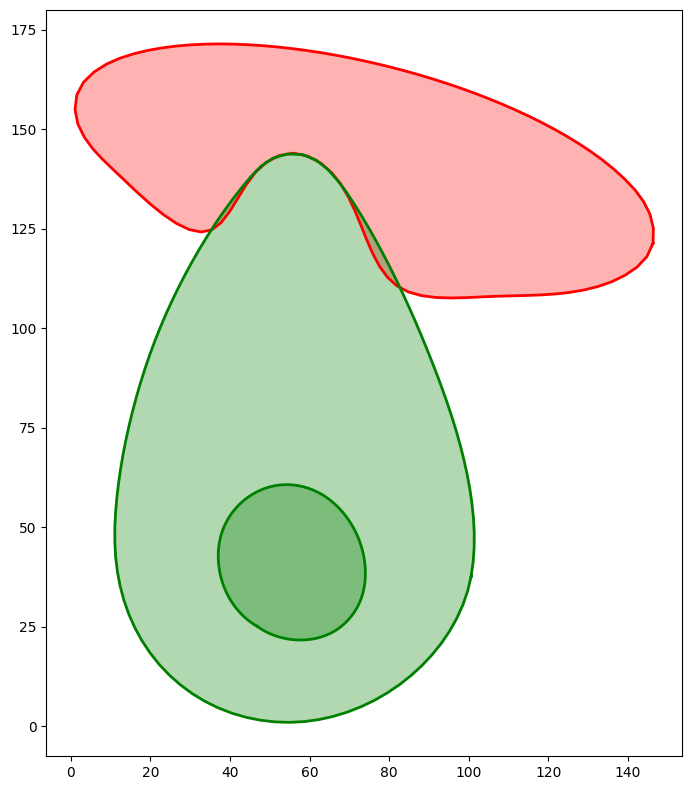

Plotting filled curves...


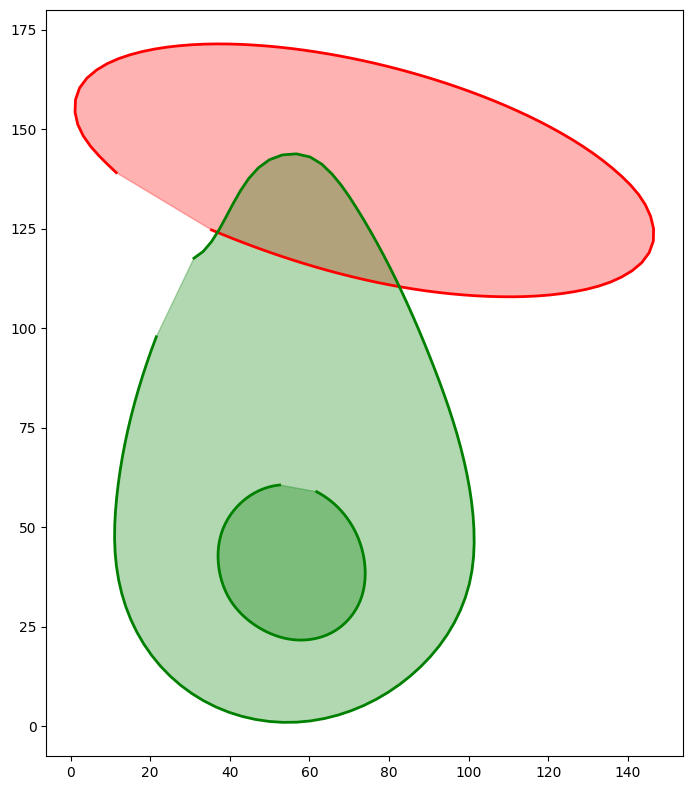

Input image: Connected
Output image: Connected
No change in connectivity


In [ ]:

input_csv = 'Test Dataset/occlusion1.csv'
colours = ['red', 'green']

fill_occlusions(input_csv, colours)

paths_XYs=read_csv(input_csv)
simplified_paths_XYs = rdp_simplify(paths_XYs, epsilon=1.0)
polylines2svg(simplified_paths_XYs, 'simplified_paths.svg', colours)

Plotting input curves...


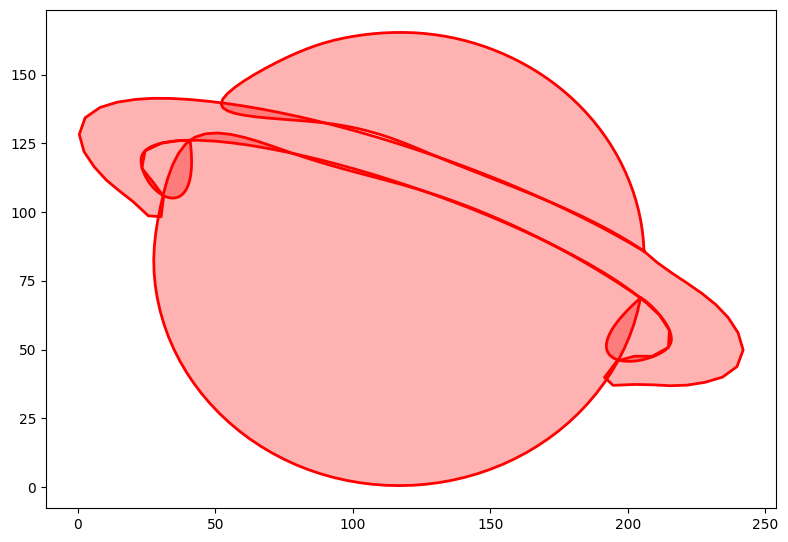

Error in connectivity analysis: 'MultiPolygon' object is not subscriptable
Plotting filled curves...


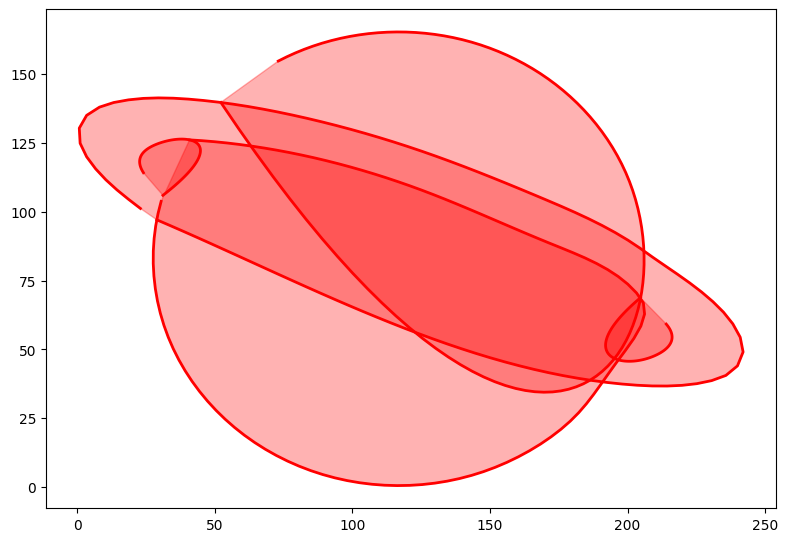

Input image: Disconnected
Output image: Connected
Occlusion has been filled


In [ ]:
input_csv = 'Test Dataset/occlusion2.csv'
colours = ['red']

fill_occlusions(input_csv, colours)

paths_XYs=read_csv(input_csv)
simplified_paths_XYs = rdp_simplify(paths_XYs, epsilon=1.0)
polylines2svg(simplified_paths_XYs, 'simplified_paths.svg', colours)